KNN com múltiplas rodadas (sem PCA)

In [ ]:
# MONTA O DRIVE
from google.colab import drive
drive.mount('/content/drive')

# IMPORTS
import pandas as pd
import cupy as cp
import numpy as np
from cuml.neighbors import KNeighborsClassifier as cuKNN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# CARREGAMENTO DO DATASET
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

# FEATURES e RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label']

# ENCODER DE RÓTULOS (ok fazer no y completo — só mapeia categorias)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

# CONFIGURAÇÕES
k = 1
n_runs = 50
test_size = 45  # pode ser int (amostras) ou fração (ex.: 0.2)

# ACUMULADORES
all_y_true = []
all_y_pred = []

for seed in range(n_runs):
    # Split ESTRATIFICADO por rodada (garante proporções por classe no teste)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=test_size,
        random_state=seed,
        stratify=y_encoded
    )

    # SCALER: FIT só no TREINO -> evita vazamento
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # CONVERSÃO PARA GPU (tipos corretos)
    X_train_cu = cp.asarray(X_train_s, dtype=cp.float32)
    X_test_cu  = cp.asarray(X_test_s,  dtype=cp.float32)
    y_train_cu = cp.asarray(y_train,   dtype=cp.int32)

    # KNN (GPU)
    knn = cuKNN(n_neighbors=k)
    knn.fit(X_train_cu, y_train_cu)
    y_pred_cu = knn.predict(X_test_cu)

    # VOLTA PARA CPU e acumula
    y_pred = cp.asnumpy(y_pred_cu)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# MÉTRICAS FINAIS
all_y_true_np = np.array(all_y_true)
all_y_pred_np = np.array(all_y_pred)

acc = (all_y_true_np == all_y_pred_np).mean()
print(f"Média de acurácia (sem PCA, GPU, k={k}, estratificado): {acc:.4f}")

# Classification report com o nome das classes originais
print("Classification Report:\n",
      classification_report(all_y_true_np, all_y_pred_np, target_names=le.classes_))

# MATRIZ DE CONFUSÃO (fixando o conjunto de rótulos)
labels_full = np.arange(n_classes)
cm = confusion_matrix(all_y_true_np, all_y_pred_np, labels=labels_full)

plt.figure(figsize=(14, 10))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, square=True, cbar=True)

plt.title(f'Matriz de Confusão (GPU, sem PCA, k={k})', fontsize=16)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Mounted at /content/drive


KeyboardInterrupt: 

KNN (com PCA)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Acurácia KNN (PCA=5): 0.8085
 Classification Report:
                              precision    recall  f1-score   support

                    Flicker       0.45      0.45      0.45     20000
     Flicker_with_harmonics       1.00      1.00      1.00     20000
           Flicker_with_sag       0.87      0.84      0.85     20000
         Flicker_with_swell       0.42      0.42      0.42     20000
                  Harmonics       1.00      1.00      1.00     20000
        Impulsive_transient       1.00      1.00      1.00     20000
               Interruption       0.67      0.69      0.68     20000
Interruption_with_harmonics       0.69      0.69      0.69     20000
                     Normal       0.58      0.59      0.58     20000
      Oscillatory_transient       1.00      1.00      1.00     20000
             Periodic_notch       1.00      1.00      1.

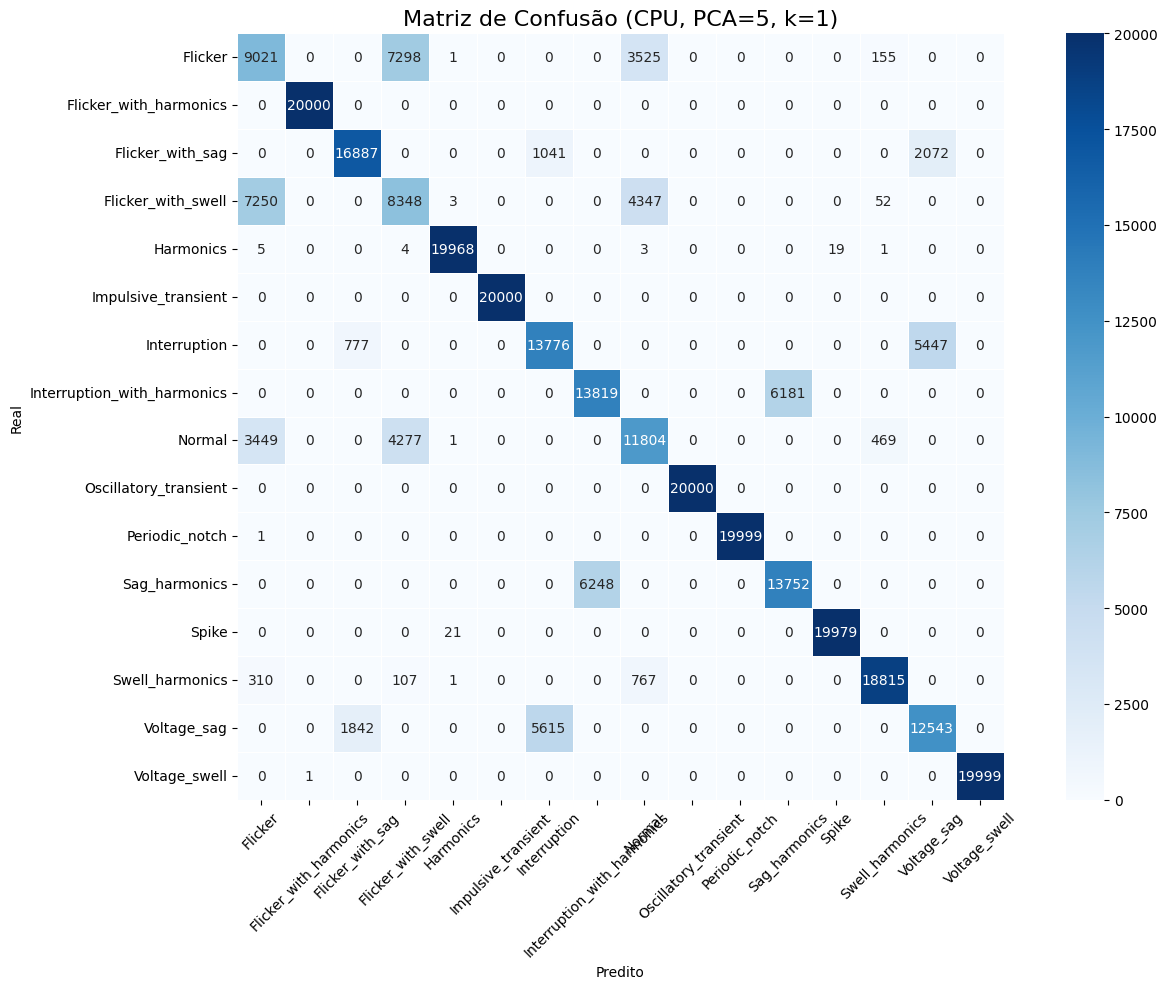

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

#  CARREGAMENTO
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

#  FEATURES / RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label'].astype(str)

#  ENCODER (pode ser no y inteiro — só mapeia categorias)
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)

#  SPLIT (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

#  PIPELINE (evita vazamento)
n_components = 5  # ou 0.95 para manter 95% da variância
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('knn', KNeighborsClassifier(n_neighbors=1, algorithm='brute', n_jobs=-1))
])

#  TREINO
pipe.fit(X_train, y_train)

# TESTE
y_pred = pipe.predict(X_test)

# MÉTRICAS
print(f" Acurácia KNN (PCA={n_components}): {accuracy_score(y_test, y_pred):.4f}")
print(" Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

#  MATRIZ DE CONFUSÃO (labels fixos)
labels_full = np.arange(n_classes)
cm = confusion_matrix(y_test, y_pred, labels=labels_full)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, square=True, cbar=True)
plt.title(f'Matriz de Confusão (CPU, PCA={n_components}, k=1)', fontsize=16)
plt.xlabel('Predito'); plt.ylabel('Real'); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# (Opcional) Validação cruzada estratificada no treino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV (5-fold) no treino — média: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


LDA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
8     0.0625
3     0.0625
15    0.0625
10    0.0625
11    0.0625
12    0.0625
14    0.0625
5     0.0625
9     0.0625
7     0.0625
0     0.0625
2     0.0625
13    0.0625
6     0.0625
1     0.0625
4     0.0625
Name: proportion, dtype: float64
 Acurácia LDA (sem vazamento): 0.9930
 Classification Report:
                              precision    recall  f1-score   support

                    Flicker       0.96      0.96      0.96     20000
     Flicker_with_harmonics       1.00      1.00      1.00     20000
           Flicker_with_sag       1.00      1.00      1.00     20000
         Flicker_with_swell       0.94      0.96      0.95     20000
                  Harmonics       1.00      1.00      1.00     20000
        Impulsive_transient       1.00      1.00      1.00     20000
               Interruption       1.00      1.00      1.00     20000
Interruption_w

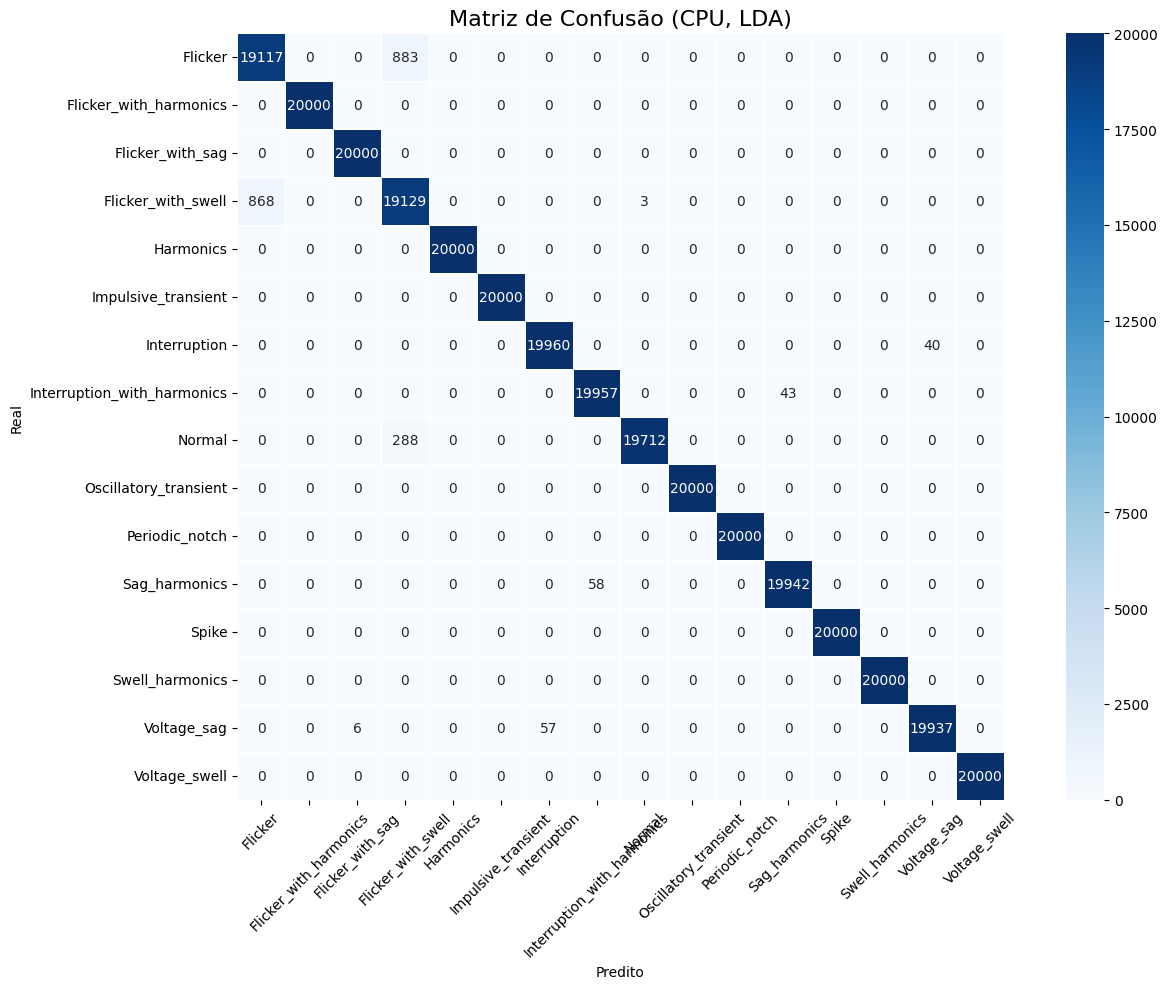

In [ ]:
#  MONTE O GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

#  IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

#  CARREGAMENTO DO DATASET
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

#  SEPARAÇÃO DE FEATURES E RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label'].astype(str)

#  ENCODING DOS RÓTULOS (ok fazer no y completo)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

#  DIVISÃO TREINO/TESTE (estratificada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#  PIPELINE: SCALER -> LDA
# Dica: para dados ruidosos/correlacionados, teste shrinkage:
# lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
lda = LinearDiscriminantAnalysis()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', lda),
])

# Treino
pipe.fit(X_train, y_train)

# Predição
y_pred = pipe.predict(X_test)

# Distribuição de classes (global)
print(pd.Series(y_encoded).value_counts(normalize=True))

# MÉTRICAS
print(f" Acurácia LDA (sem vazamento): {accuracy_score(y_test, y_pred):.4f}")
print(" Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

# MATRIZ DE CONFUSÃO (fixando labels)
labels_full = np.arange(n_classes)
cm = confusion_matrix(y_test, y_pred, labels=labels_full)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, square=True, cbar=True)
plt.title('Matriz de Confusão (CPU, LDA)', fontsize=16)
plt.xlabel('Predito'); plt.ylabel('Real'); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()



Gaussian Naive Bayes

Mounted at /content/drive
✅ Gaussian Naive Bayes Accuracy: 0.9726
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     19796
           1       1.00      1.00      1.00     19810
           2       0.98      1.00      0.99     19999
           3       0.82      0.81      0.81     19748
           4       1.00      1.00      1.00     19999
           5       1.00      1.00      1.00     20012
           6       1.00      0.98      0.99     20080
           7       1.00      0.98      0.99     20025
           8       0.99      0.85      0.92     20371
           9       1.00      1.00      1.00     20052
          10       1.00      1.00      1.00     20129
          11       0.98      1.00      0.99     20080
          12       1.00      1.00      1.00     19912
          13       1.00      1.00      1.00     20101
          14       0.98      0.98      0.98     20029
          15       1.00      1.00      1.00

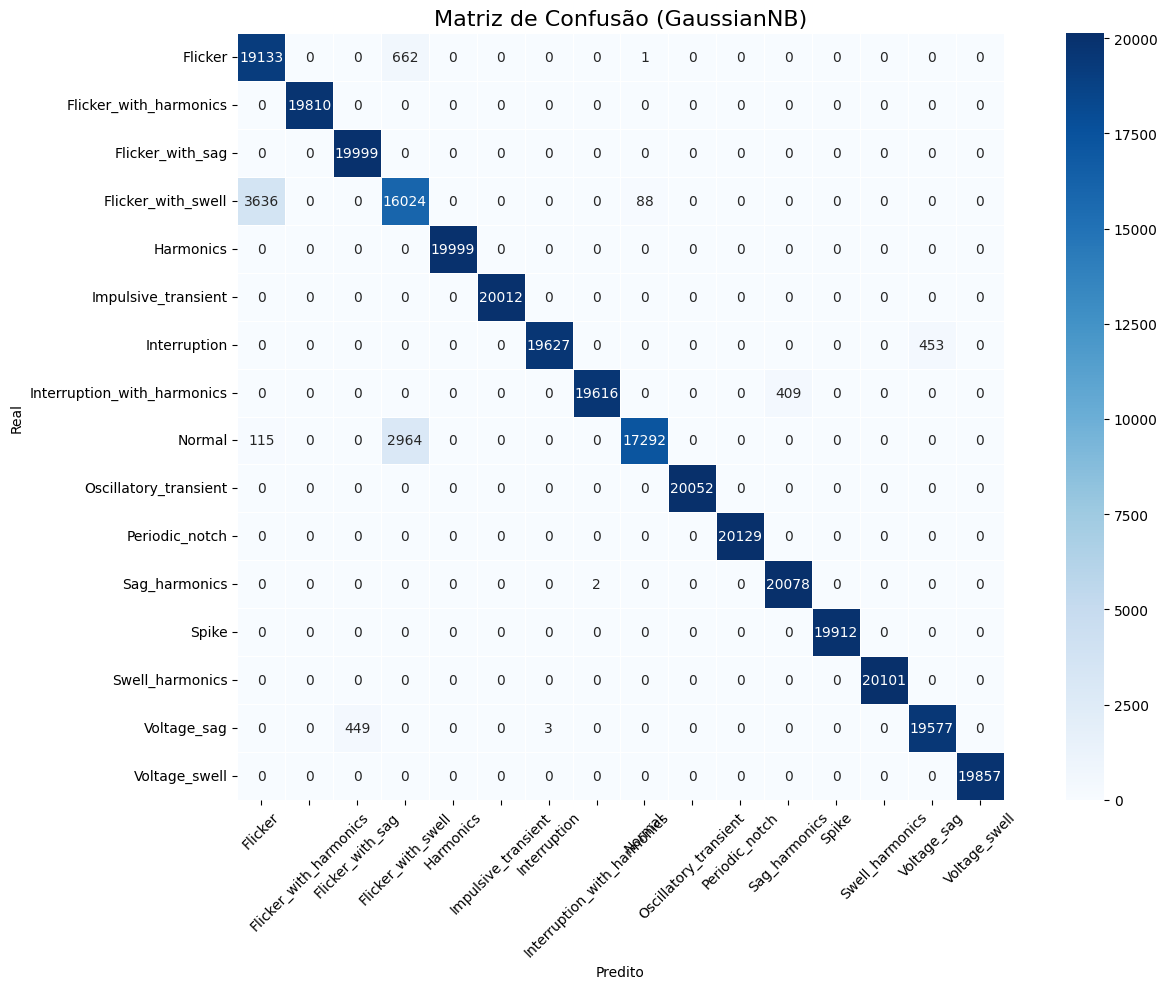

🔁 Acurácia média com validação cruzada (cv=5, GaussianNB): 0.97 (+/- 0.00)


In [ ]:
#  MONTE O GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

#  IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

#  CARREGAMENTO DO DATASET
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

#  FEATURES / RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label'].astype(str)

#  ENCODING (ok fazer no y completo)
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)

#  SPLIT estratificado (evita desbalancear o teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

#  PIPELINE: (Scaler -> GaussianNB) para evitar vazamento em treino/teste e na CV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

#  TREINO
pipe.fit(X_train, y_train)

#  TESTE
y_pred = pipe.predict(X_test)

#  MÉTRICAS
print(f" GaussianNB Accuracy (sem vazamento): {accuracy_score(y_test, y_pred):.4f}")
print(" Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

#  MATRIZ DE CONFUSÃO (fixando o conjunto completo de labels)
labels_full = np.arange(n_classes)
cm = confusion_matrix(y_test, y_pred, labels=labels_full)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, square=True, cbar=True)
plt.title('Matriz de Confusão (GaussianNB)', fontsize=16)
plt.xlabel('Predito'); plt.ylabel('Real'); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

#  VALIDAÇÃO CRUZADA correta (no pipeline) com estratificação
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
print(" Acurácia média CV (cv=5, GaussianNB, sem vazamento): "
      f"{scores.mean():.4f} (+/- {2*scores.std():.4f})")

#  OPCIONAL: afinar var_smoothing (estabilidade numérica da variância)
param_grid = {'nb__var_smoothing': np.logspace(-12, -6, 7)}
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs.fit(X, y_enc)
print(f" Melhor var_smoothing: {gs.best_params_['nb__var_smoothing']}, "
      f"melhor acc CV: {gs.best_score_:.4f}")


SVM com múltiplos kernels

In [ ]:
#  MONTE O GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

#  IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#  CARREGAMENTO DO DATASET
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

#  SEPARAÇÃO DE FEATURES E RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label']

#  ENCODING DOS RÓTULOS
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#  NORMALIZAÇÃO
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

#  DIVISÃO TREINO/TESTE
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

#  TESTE COM DIFERENTES KERNELS
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    print(f"\n Kernel: {kernel.upper()} ")

    # Treinamento do modelo
    svm_model = SVC(kernel=kernel, C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f" Acurácia SVM ({kernel}): {acc:.4f}")
    print(" Classification Report:\n", classification_report(y_test, y_pred))

    # Matrizes de confusão bonitas
    plt.figure(figsize=(14, 10))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, square=True, cbar=True)

    plt.title(f'Matriz de Confusão (SVM kernel="{kernel}")', fontsize=16)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Validação cruzada
   # scores = cross_val_score(SVC(kernel=kernel, C=1.0, gamma='scale'),
    #                         X_normalized, y_encoded, cv=5, n_jobs=-1)
  #  print(" Validação cruzada (cv=5): Média = %.2f | Desvio = %.2f" % (scores.mean(), scores.std() * 2))


Mounted at /content/drive

🔷🔷🔷 Kernel: LINEAR 🔷🔷🔷


GridSearchCV para SVM

In [ ]:
#  MONTE O GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

#  IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#  CARREGAMENTO DO DATASET
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

#  SEPARAÇÃO DE FEATURES E RÓTULOS
X = df.drop(columns=['Label'])
y = df['Label']

#  ENCODING DOS RÓTULOS
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#  NORMALIZAÇÃO
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

#  DIVISÃO TREINO/TESTE
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

#  GRID SEARCH COM CROSS-VALIDATION (SVM linear)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# RESULTADOS
print(" Melhores parâmetros encontrados:", grid.best_params_)

#  AVALIAÇÃO DO MODELO FINAL
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n Acurácia final com melhores parâmetros: {acc:.4f}")
print(" Classification Report:\n", classification_report(y_test, y_pred))

#  MATRIZ DE CONFUSÃO BONITA
plt.figure(figsize=(14, 10))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, square=True, cbar=True)

plt.title('Matriz de Confusão (SVM otimizado com GridSearch)', fontsize=16)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import torch


print("CUDA disponível:", torch.cuda.is_available())

if torch.cuda.is_available():
    print(" GPU detectada:", torch.cuda.get_device_name(0))
    print("Número de GPUs disponíveis:", torch.cuda.device_count())
    print("Memória total da GPU (MB):", torch.cuda.get_device_properties(0).total_memory // (1024 * 1024))
    print("Dispositivo atual:", torch.cuda.current_device())
else:
    print(" Nenhuma GPU CUDA foi detectada.")
    print(" Verifique se o PyTorch com suporte CUDA está instalado corretamente.")

CUDA disponível: True
✅ GPU detectada: NVIDIA A100-SXM4-80GB
Número de GPUs disponíveis: 1
Memória total da GPU (MB): 81221
Dispositivo atual: 0


FT- DB8_LEVEL4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dispositivo: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.3281 | Val 0.5101


Epoch 02 | Train 0.9223 | Val 0.4375


Epoch 03 | Train 0.8507 | Val 0.4707


Epoch 04 | Train 0.7973 | Val 0.4001


Epoch 05 | Train 0.7670 | Val 0.3982


Epoch 06 | Train 0.7458 | Val 0.3898


Epoch 07 | Train 0.7359 | Val 0.3746


Epoch 08 | Train 0.7255 | Val 0.3786


Epoch 09 | Train 0.7038 | Val 0.3698


Epoch 10 | Train 0.7065 | Val 0.3686


Epoch 11 | Train 0.6946 | Val 0.3660


Epoch 12 | Train 0.6962 | Val 0.3642


Epoch 13 | Train 0.6920 | Val 0.3696


Epoch 14 | Train 0.6933 | Val 0.3570


Epoch 15 | Train 0.6877 | Val 0.3847


Epoch 16 | Train 0.6812 | Val 0.3563


Epoch 17 | Train 0.6804 | Val 0.3671


Epoch 18 | Train 0.6759 | Val 0.3767


Epoch 19 | Train 0.6668 | Val 0.3563


Epoch 20 | Train 0.6691 | Val 0.3493


Epoch 21 | Train 0.6676 | Val 0.3598


Epoch 22 | Train 0.6672 | Val 0.3521


Epoch 23 | Train 0.6556 | Val 0.3580


Epoch 24 | Train 0.6559 | Val 0.3446


Epoch 25 | Train 0.6577 | Val 0.3454


Epoch 26 | Train 0.6568 | Val 0.3462


Epoch 27 | Train 0.6571 | Val 0.3522


Epoch 28 | Train 0.6542 | Val 0.3438


Epoch 29 | Train 0.6427 | Val 0.3423


Epoch 30 | Train 0.6506 | Val 0.3451


Epoch 31 | Train 0.6452 | Val 0.3398


Epoch 32 | Train 0.6418 | Val 0.3406


Epoch 33 | Train 0.6416 | Val 0.3551


Epoch 34 | Train 0.6390 | Val 0.3448


Epoch 35 | Train 0.6440 | Val 0.3397


Epoch 36 | Train 0.6356 | Val 0.3467


Epoch 37 | Train 0.6384 | Val 0.3411


Epoch 38 | Train 0.6398 | Val 0.3434


Epoch 39 | Train 0.6363 | Val 0.3435


Epoch 40 | Train 0.6359 | Val 0.3435
Early stopping!

 Tempo total: 9815.78s

 Acurácia Teste: 0.9935

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.95      0.97      0.96     10000
     Flicker_with_harmonics       1.00      1.00      1.00     10000
           Flicker_with_sag       1.00      1.00      1.00     10000
         Flicker_with_swell       0.97      0.94      0.96     10000
                  Harmonics       1.00      1.00      1.00     10000
        Impulsive_transient       1.00      1.00      1.00     10000
               Interruption       1.00      1.00      1.00     10000
Interruption_with_harmonics       0.99      1.00      0.99     10000
                     Normal       1.00      1.00      1.00     10000
      Oscillatory_transient       1.00      1.00      1.00     10000
             Periodic_notch       1.00      1.00      1.00     10000
              Sag_harmonics       1.00      0.99      0

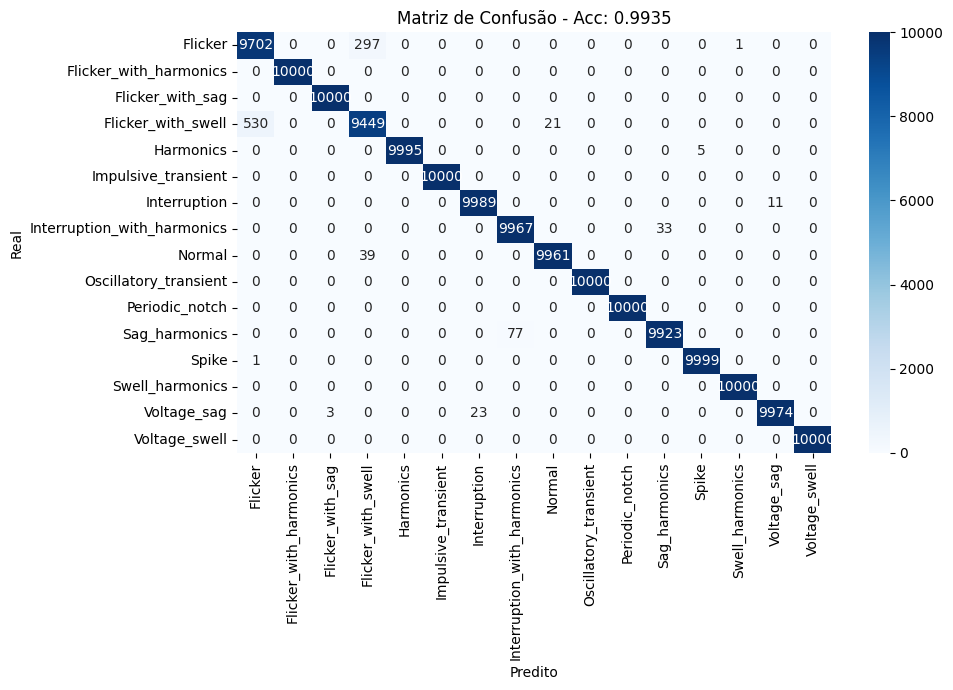

AttributeError: Line2D.set() got an unexpected keyword argument 'fontsize'

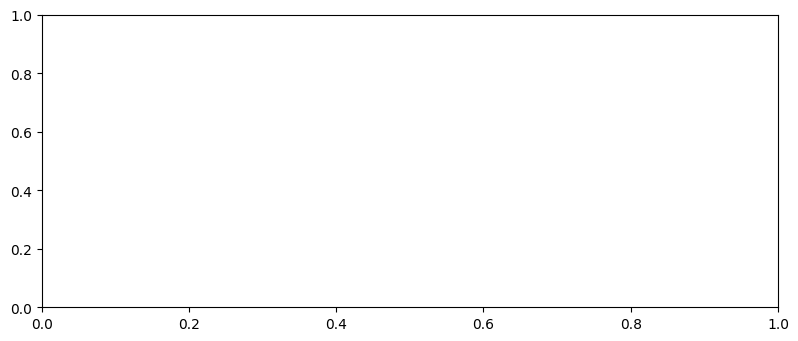

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots
# ============================

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.tight_layout(); plt.show()


fig, ax = plt.subplots(figsize=(9.5, 3.8))
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, linewidth=2, label='train', color='tab:blue',fontsize=19)
ax.plot(np.arange(1, len(train_losses) + 1), val_losses,   linewidth=2, label='Validation',   color='tab:red', fontsize=19)
ax.set_xlabel('Epoch', fontsize=22)
ax.set_ylabel('Loss', fontsize= 22)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
step = max(1, len(epoch) // 8)
ax.set_xticks(epochs[::step])
plt.tight_layout()
plt.show()

FT- db6_level_4

Mounted at /content/drive
 Dispositivo: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.1667 | Val 0.4927


Epoch 02 | Train 0.8902 | Val 0.4851


Epoch 03 | Train 0.8309 | Val 0.4537


Epoch 04 | Train 0.7958 | Val 0.4157


Epoch 05 | Train 0.7530 | Val 0.3990


Epoch 06 | Train 0.7349 | Val 0.3908


Epoch 07 | Train 0.7266 | Val 0.3787


Epoch 08 | Train 0.7162 | Val 0.3710


Epoch 09 | Train 0.7091 | Val 0.3727


Epoch 10 | Train 0.6984 | Val 0.3692


Epoch 11 | Train 0.6977 | Val 0.3865


Epoch 12 | Train 0.6858 | Val 0.3759


Epoch 13 | Train 0.6895 | Val 0.3545


Epoch 14 | Train 0.6876 | Val 0.3600


Epoch 15 | Train 0.6795 | Val 0.3518


Epoch 16 | Train 0.6769 | Val 0.3540


Epoch 17 | Train 0.6729 | Val 0.3454


Epoch 18 | Train 0.6712 | Val 0.3533


Epoch 19 | Train 0.6702 | Val 0.3462


Epoch 20 | Train 0.6648 | Val 0.3522


Epoch 21 | Train 0.6622 | Val 0.3482


Epoch 22 | Train 0.6620 | Val 0.3478
Early stopping!

⏱️ Tempo total: 11075.95s

 Acurácia Teste: 0.9911

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.95      0.95      0.95     20000
     Flicker_with_harmonics       1.00      1.00      1.00     20000
           Flicker_with_sag       1.00      1.00      1.00     20000
         Flicker_with_swell       0.95      0.95      0.95     20000
                  Harmonics       1.00      1.00      1.00     20000
        Impulsive_transient       1.00      1.00      1.00     20000
               Interruption       1.00      1.00      1.00     20000
Interruption_with_harmonics       0.98      0.99      0.98     20000
                     Normal       1.00      1.00      1.00     20000
      Oscillatory_transient       1.00      1.00      1.00     20000
             Periodic_notch       1.00      1.00      1.00     20000
              Sag_harmonics       0.99      0.98    

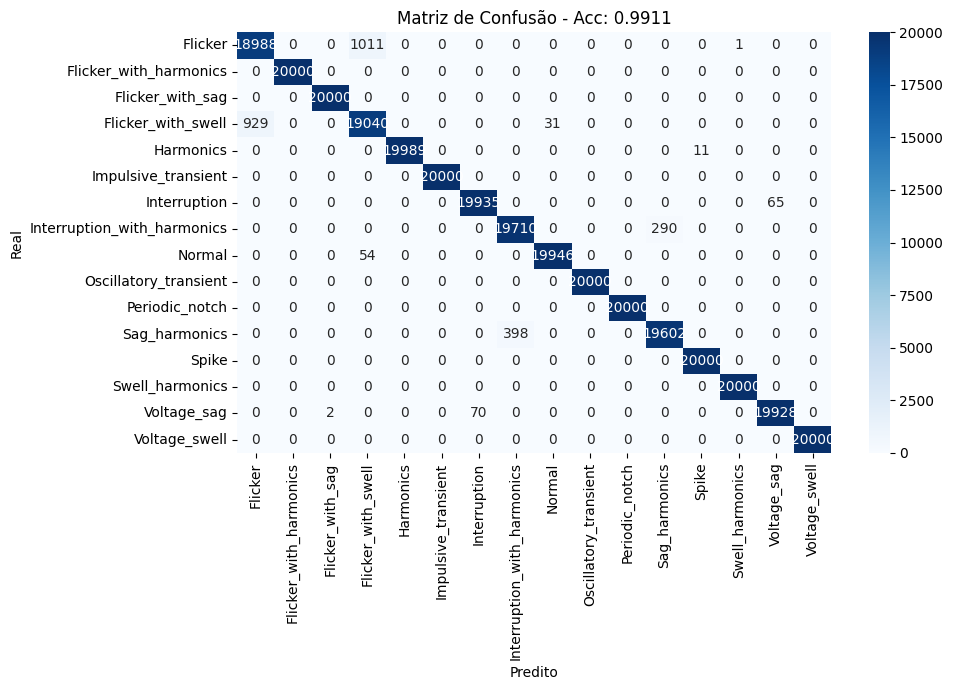

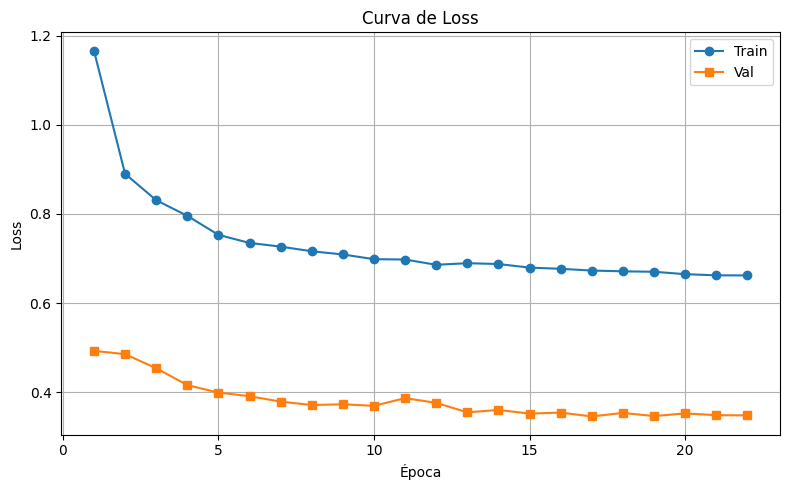

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db6_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n⏱️ Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots
# ============================

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
plt.plot(range(1,len(val_losses)+1),   val_losses,   marker='s', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de Loss")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


db4_level_4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dispositivo: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.0520 | Val 0.5004


Epoch 02 | Train 0.8487 | Val 0.4826


Epoch 03 | Train 0.7806 | Val 0.4038


Epoch 04 | Train 0.7491 | Val 0.3905


Epoch 05 | Train 0.7222 | Val 0.3830


Epoch 06 | Train 0.7055 | Val 0.3706


Epoch 07 | Train 0.7010 | Val 0.3699


Epoch 08 | Train 0.6901 | Val 0.3552


Epoch 09 | Train 0.6839 | Val 0.3672


Epoch 10 | Train 0.6799 | Val 0.3565


Epoch 11 | Train 0.6752 | Val 0.3743


Epoch 12 | Train 0.6735 | Val 0.3551


Epoch 13 | Train 0.6713 | Val 0.3456


Epoch 14 | Train 0.6610 | Val 0.3478


Epoch 15 | Train 0.6612 | Val 0.3427


Epoch 16 | Train 0.6609 | Val 0.3434


Epoch 17 | Train 0.6587 | Val 0.3520


Epoch 18 | Train 0.6539 | Val 0.3457


Epoch 19 | Train 0.6555 | Val 0.3461


Epoch 20 | Train 0.6528 | Val 0.3444
Early stopping!

⏱️ Tempo total: 20141.73s

 Acurácia Teste: 0.9911

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.96      0.95      0.96     40000
     Flicker_with_harmonics       1.00      1.00      1.00     40000
           Flicker_with_sag       1.00      1.00      1.00     40000
         Flicker_with_swell       0.95      0.96      0.95     40000
                  Harmonics       1.00      1.00      1.00     40000
        Impulsive_transient       1.00      1.00      1.00     40000
               Interruption       0.99      1.00      1.00     40000
Interruption_with_harmonics       0.97      0.99      0.98     40000
                     Normal       1.00      1.00      1.00     40000
      Oscillatory_transient       1.00      1.00      1.00     40000
             Periodic_notch       1.00      1.00      1.00     40000
              Sag_harmonics       0.99      0.97    

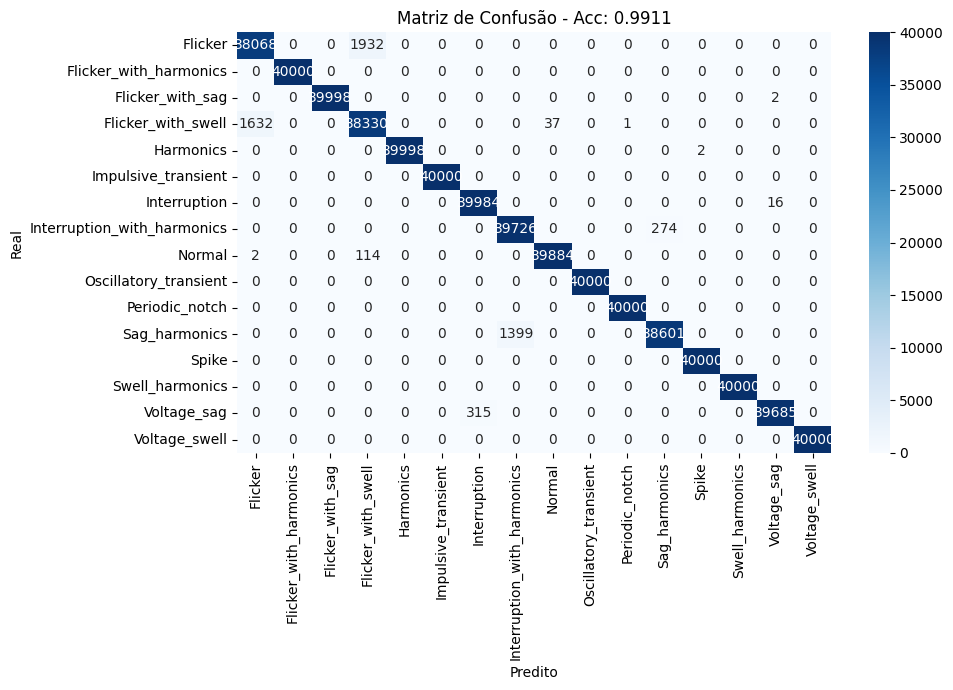

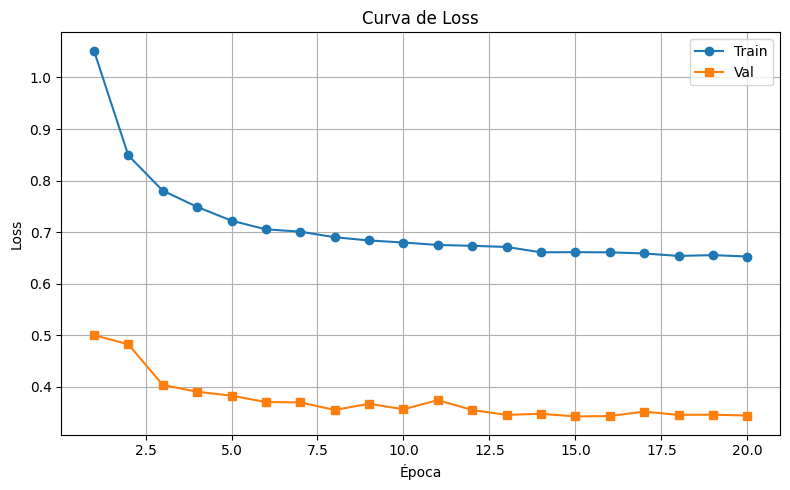

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db4_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n⏱️ Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots
# ============================

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
plt.plot(range(1,len(val_losses)+1),   val_losses,   marker='s', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de Loss")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


FT- DB4 -LEVEL6

Mounted at /content/drive
 Dispositivo: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.3249 | Val 0.4849


Epoch 02 | Train 0.8610 | Val 0.4369


Epoch 03 | Train 0.7936 | Val 0.4075


Epoch 04 | Train 0.7481 | Val 0.3746


Epoch 05 | Train 0.7205 | Val 0.3736


Epoch 06 | Train 0.7018 | Val 0.3817


Epoch 07 | Train 0.6926 | Val 0.3530


Epoch 08 | Train 0.6832 | Val 0.3629


Epoch 09 | Train 0.6630 | Val 0.3524


Epoch 10 | Train 0.6656 | Val 0.3497


Epoch 11 | Train 0.6563 | Val 0.3518


Epoch 12 | Train 0.6574 | Val 0.3611


Epoch 13 | Train 0.6532 | Val 0.3602


Epoch 14 | Train 0.6547 | Val 0.3496


Epoch 15 | Train 0.6499 | Val 0.3481


Epoch 16 | Train 0.6442 | Val 0.3447


Epoch 17 | Train 0.6432 | Val 0.3484


Epoch 18 | Train 0.6401 | Val 0.3457


Epoch 19 | Train 0.6324 | Val 0.3467


Epoch 20 | Train 0.6340 | Val 0.3468


Epoch 21 | Train 0.6329 | Val 0.3480
Early stopping!

⏱️ Tempo total: 22264.10s

 Acurácia Teste: 0.9909

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.96      0.99      0.97     10000
     Flicker_with_harmonics       1.00      1.00      1.00     10000
           Flicker_with_sag       1.00      1.00      1.00     10000
         Flicker_with_swell       0.99      0.96      0.97     10000
                  Harmonics       1.00      1.00      1.00     10000
        Impulsive_transient       1.00      1.00      1.00     10000
               Interruption       1.00      1.00      1.00     10000
Interruption_with_harmonics       0.97      0.94      0.96     10000
                     Normal       1.00      1.00      1.00     10000
      Oscillatory_transient       1.00      1.00      1.00     10000
             Periodic_notch       1.00      1.00      1.00     10000
              Sag_harmonics       0.95      0.97    

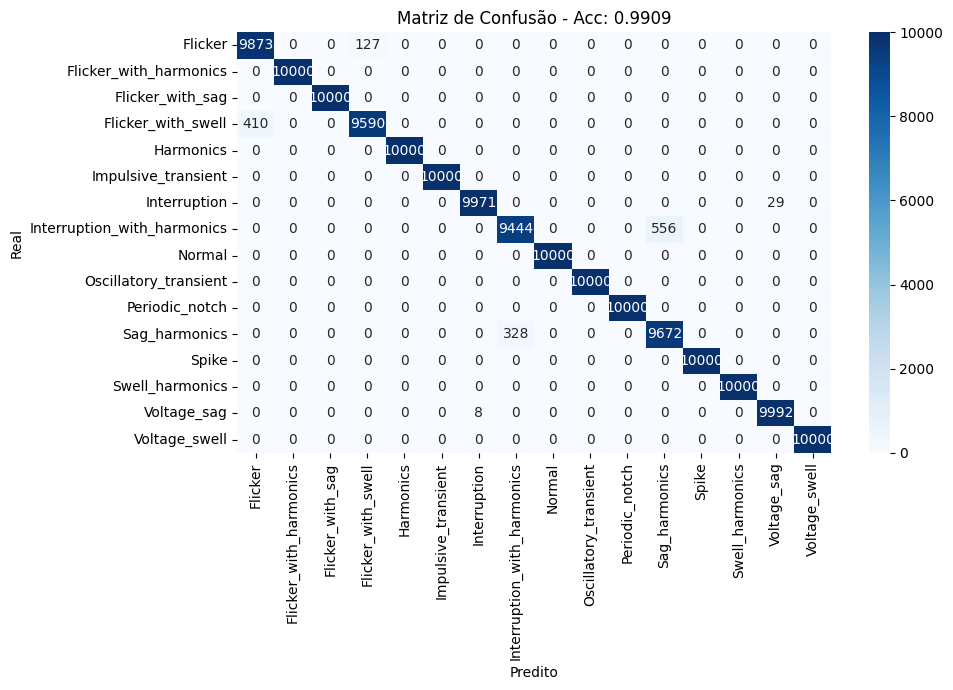

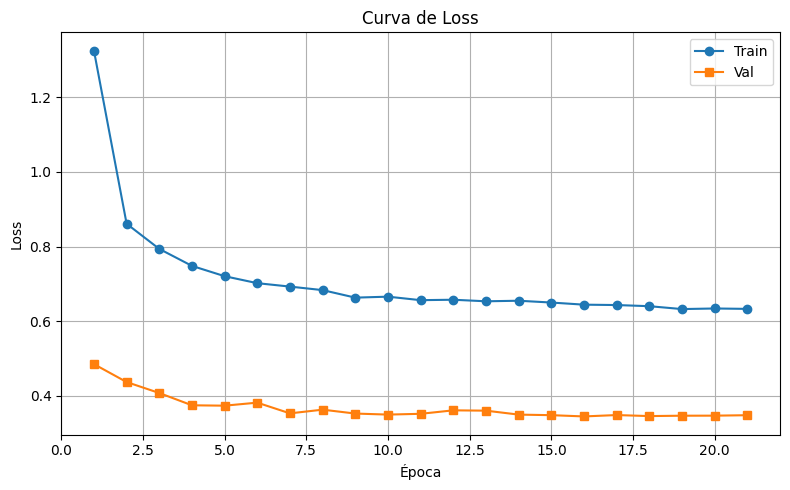

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db4_level_6.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n⏱️ Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots
# ============================

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
plt.plot(range(1,len(val_losses)+1),   val_losses,   marker='s', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de Loss")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


db8_level_6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dispositivo: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.3220 | Val 0.4969


Epoch 02 | Train 0.8691 | Val 0.4166


Epoch 03 | Train 0.8009 | Val 0.4056


Epoch 04 | Train 0.7524 | Val 0.3845


Epoch 05 | Train 0.7257 | Val 0.3961


Epoch 06 | Train 0.7078 | Val 0.3744


Epoch 07 | Train 0.6981 | Val 0.3582


Epoch 08 | Train 0.6892 | Val 0.3621


Epoch 09 | Train 0.6689 | Val 0.3595


Epoch 10 | Train 0.6705 | Val 0.3545


Epoch 11 | Train 0.6605 | Val 0.3528


Epoch 12 | Train 0.6619 | Val 0.3620


Epoch 13 | Train 0.6576 | Val 0.3553


Epoch 14 | Train 0.6587 | Val 0.3491


Epoch 15 | Train 0.6535 | Val 0.3684


Epoch 16 | Train 0.6482 | Val 0.3485


Epoch 17 | Train 0.6469 | Val 0.3493


Epoch 18 | Train 0.6442 | Val 0.3514


Epoch 19 | Train 0.6359 | Val 0.3508


Epoch 20 | Train 0.6372 | Val 0.3535


Epoch 21 | Train 0.6363 | Val 0.3550
Early stopping!

⏱️ Tempo total: 22240.25s

 Acurácia Teste: 0.9895

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.98      0.97      0.97     10000
     Flicker_with_harmonics       1.00      1.00      1.00     10000
           Flicker_with_sag       1.00      1.00      1.00     10000
         Flicker_with_swell       0.97      0.98      0.98     10000
                  Harmonics       1.00      1.00      1.00     10000
        Impulsive_transient       1.00      1.00      1.00     10000
               Interruption       0.99      1.00      1.00     10000
Interruption_with_harmonics       0.96      0.93      0.94     10000
                     Normal       1.00      1.00      1.00     10000
      Oscillatory_transient       1.00      1.00      1.00     10000
             Periodic_notch       1.00      1.00      1.00     10000
              Sag_harmonics       0.93      0.96    

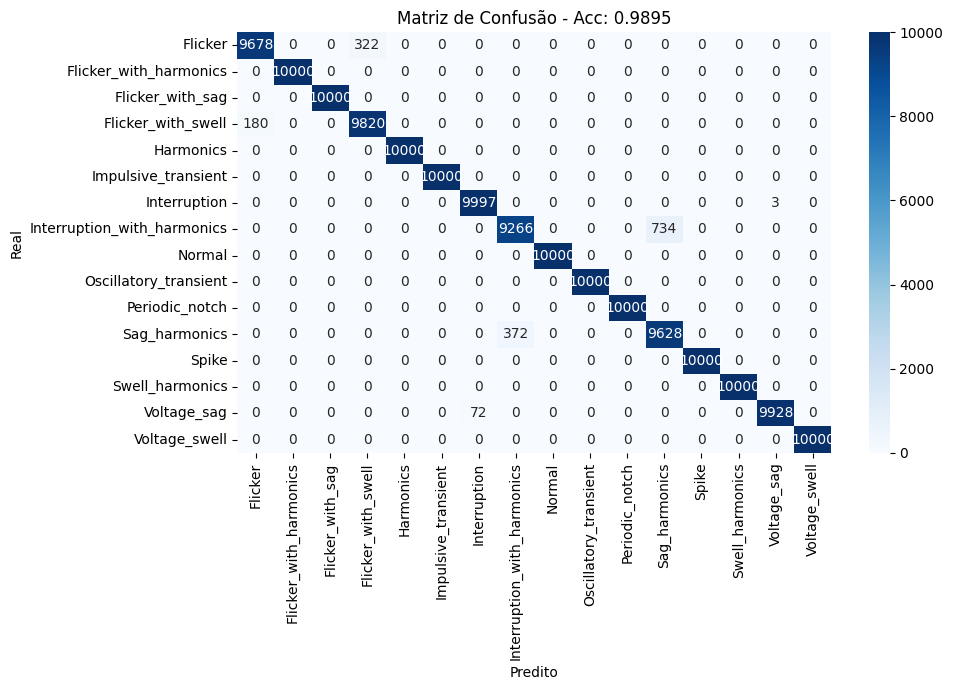

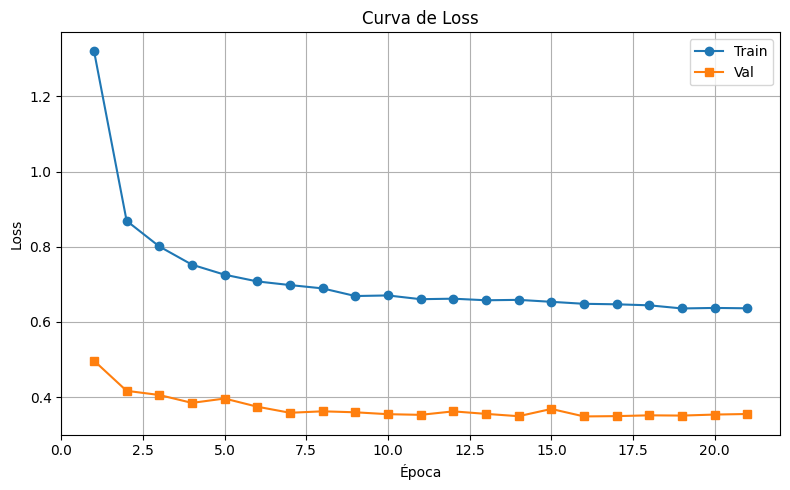

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_6.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n⏱️ Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots
# ============================

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
plt.plot(range(1,len(val_losses)+1),   val_losses,   marker='s', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de Loss")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


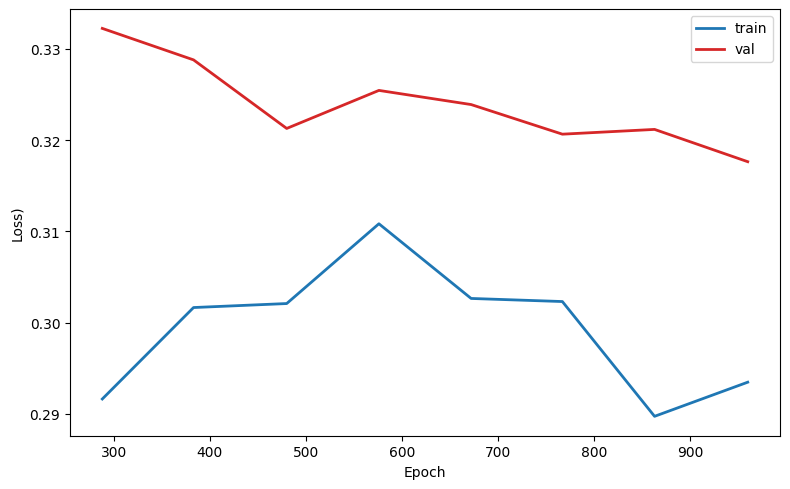

In [ ]:
# ==========================================
# 7) CURVA DE LOSS (Log-Loss) — SÓ LINHAS
# ==========================================
from sklearn.model_selection import StratifiedKFold, learning_curve

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes = np.linspace(0.3, 1.0, 8)

train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X, y=y_encoded,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_log_loss',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_loss_mean = -train_scores.mean(axis=1)
val_loss_mean   = -val_scores.mean(axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_abs, train_loss_mean, linewidth=2, label='train',
         color='tab:blue')
plt.plot(train_sizes_abs, val_loss_mean,   linewidth=2, label='val',
         color='tab:red')

plt.xlabel('Epoch')
plt.ylabel('Loss)')
plt.legend()
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dispositivo: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 1.3281 | Val 0.5101


Epoch 02 | Train 0.9223 | Val 0.4375


Epoch 03 | Train 0.8507 | Val 0.4707


Epoch 04 | Train 0.7973 | Val 0.4001


Epoch 05 | Train 0.7670 | Val 0.3982


Epoch 06 | Train 0.7458 | Val 0.3898


Epoch 07 | Train 0.7359 | Val 0.3746


Epoch 08 | Train 0.7255 | Val 0.3786


Epoch 09 | Train 0.7038 | Val 0.3698


Epoch 10 | Train 0.7065 | Val 0.3686


Epoch 11 | Train 0.6946 | Val 0.3660


Epoch 12 | Train 0.6962 | Val 0.3642


Epoch 13 | Train 0.6920 | Val 0.3696


Epoch 14 | Train 0.6933 | Val 0.3570


Epoch 15 | Train 0.6877 | Val 0.3847


Epoch 16 | Train 0.6812 | Val 0.3563


Epoch 17 | Train 0.6804 | Val 0.3671


Epoch 18 | Train 0.6759 | Val 0.3767


Epoch 19 | Train 0.6668 | Val 0.3563


Epoch 20 | Train 0.6691 | Val 0.3493


Epoch 21 | Train 0.6676 | Val 0.3598


Epoch 22 | Train 0.6672 | Val 0.3521


Epoch 23 | Train 0.6556 | Val 0.3580


Epoch 24 | Train 0.6559 | Val 0.3446


Epoch 25 | Train 0.6577 | Val 0.3454


Epoch 26 | Train 0.6568 | Val 0.3462


Epoch 27 | Train 0.6571 | Val 0.3522


Epoch 28 | Train 0.6542 | Val 0.3438


Epoch 29 | Train 0.6427 | Val 0.3423


Epoch 30 | Train 0.6506 | Val 0.3451


Epoch 31 | Train 0.6452 | Val 0.3398


Epoch 32 | Train 0.6418 | Val 0.3406


Epoch 33 | Train 0.6416 | Val 0.3551


Epoch 34 | Train 0.6390 | Val 0.3448


Epoch 35 | Train 0.6440 | Val 0.3397


Epoch 36 | Train 0.6356 | Val 0.3467


Epoch 37 | Train 0.6384 | Val 0.3411


Epoch 38 | Train 0.6398 | Val 0.3434


Epoch 39 | Train 0.6363 | Val 0.3435


Epoch 40 | Train 0.6359 | Val 0.3435
Early stopping!

 Tempo total: 9874.24s

 Acurácia Teste: 0.9935

 Relatório:
                              precision    recall  f1-score   support

                    Flicker       0.95      0.97      0.96     10000
     Flicker_with_harmonics       1.00      1.00      1.00     10000
           Flicker_with_sag       1.00      1.00      1.00     10000
         Flicker_with_swell       0.97      0.94      0.96     10000
                  Harmonics       1.00      1.00      1.00     10000
        Impulsive_transient       1.00      1.00      1.00     10000
               Interruption       1.00      1.00      1.00     10000
Interruption_with_harmonics       0.99      1.00      0.99     10000
                     Normal       1.00      1.00      1.00     10000
      Oscillatory_transient       1.00      1.00      1.00     10000
             Periodic_notch       1.00      1.00      1.00     10000
              Sag_harmonics       1.00      0.99      0

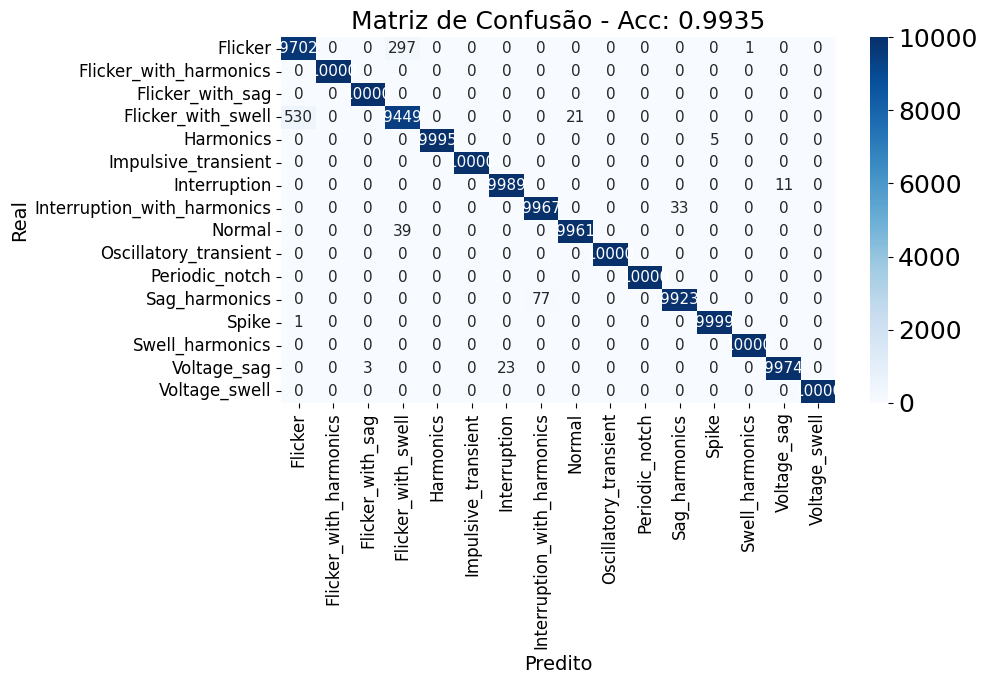

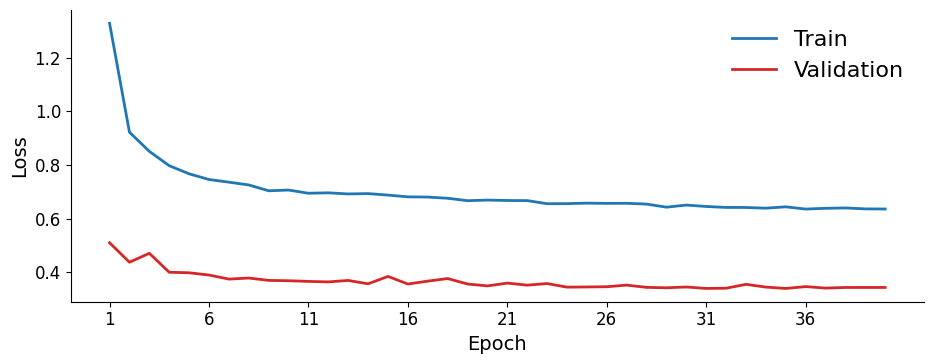

In [ ]:
# ============================
# 0. Imports e Configurações
# ============================
from google.colab import drive
drive.mount('/content/drive')

import os, time, random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ---------- Ajustes globais de fonte (altere os números como preferir) ----------
mpl.rcParams.update({
    'font.size': 12,         # base
    'axes.titlesize': 16,    # título do gráfico
    'axes.labelsize': 14,    # rótulos dos eixos
    'xtick.labelsize': 18,   # ticks eixo x
    'ytick.labelsize': 18,   # ticks eixo y
    'legend.fontsize': 20,   # <- TAMANHO DA LEGENDA (Train/Validation)
    'legend.title_fontsize': 16
})

# ---------- Seeds ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# ============================
# 1. Dados (sem leakage)
# ============================
caminho_arquivo = '/content/drive/MyDrive/sinais_features01_csv/dataset_sinais_db8_level_4.csv'
df = pd.read_csv(caminho_arquivo, sep=';')

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_val_scaled   = scaler.transform(X_val.select_dtypes(include=[np.number]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=[np.number]))

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

# ============================
# 2. Tensores & Loaders
# ============================
def to_tensor(X, y):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, seq_len, 1)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train_enc)
X_val_t,   y_val_t   = to_tensor(X_val_scaled,   y_val_enc)
X_test_t,  y_test_t  = to_tensor(X_test_scaled,  y_test_enc)

batch_size  = 256
num_workers = 2

pinmem = True if device.type == "cuda" else False
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pinmem)

val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pinmem)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pinmem)

# ============================
# 3. Modelo (FT-Transformer)
# ============================

class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim

        self.embedding = nn.Linear(1, d_model)
        self.activation = nn.GELU()
        self.pre_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, input_dim + 1, d_model))

        # Head MLP
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        x = self.embedding(x)
        x = self.activation(x)
        x = self.pre_norm(x)
        x = self.dropout(x)

        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), dim=1)                           # (B, 1+seq, d_model)
        x = x + self.pos_embed[:, :x.size(1), :]                 # positional info

        x = self.transformer(x)
        x = self.dropout(x[:, 0, :])                             # CLS
        return self.head(x)

model = FTTransformer(input_dim=X_train_t.shape[1],
                      num_classes=len(label_encoder.classes_)).to(device)

# ===================================================
# 4. Loss (label smoothing) + Optimizer + OneCycleLR
# ===================================================

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 40
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4
)

# ============================
# 5. Mixup utils
# ============================

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ============================
# 6. Treino + Validação + EarlyStopping
# ============================

patience = 5
best_val = float('inf')
wait = 0
train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch_X, batch_y in pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # mixup
        inputs, ya, yb, lam = mixup_data(batch_X, batch_y, alpha=0.2)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = mixup_criterion(criterion, logits, ya, yb, lam)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)   # sem mixup na validação
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:02d} | Train {avg_train:.4f} | Val {avg_val:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

print(f"\n Tempo total: {time.time()-start_time:.2f}s")

# ============================
# 7. Teste
# ============================

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X)
        y_pred.extend(torch.argmax(logits, dim=1).cpu().numpy())

acc = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test_enc, y_pred)

print(f"\n Acurácia Teste: {acc:.4f}")
print("\n Relatório:\n", report)

# ============================
# 8. Plots (com tamanhos e fix)
# ============================

# --- Matriz de confusão ---
plt.figure(figsize=(10,7))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={'size': 11}      # números dentro das células
)
plt.title(f"Matriz de Confusão - Acc: {acc:.4f}", fontsize=18)
plt.xlabel("Predito", fontsize=14)
plt.ylabel("Real", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- Curvas de loss (Train/Validation) ---
epochs = np.arange(1, len(train_losses) + 1)  # cria vetor de épocas

fig, ax = plt.subplots(figsize=(9.5, 3.8))
ax.plot(epochs, train_losses, linewidth=2, label='Train', color='tab:blue')
ax.plot(epochs, val_losses,   linewidth=2, label='Validation', color='tab:red')

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# LEGENDA MAIOR (Train/Validation):
leg = ax.legend(frameon=False, fontsize=16)  # aumente para 18/20 se quiser
# (opcional) deixar semi-negrito:
# for txt in leg.get_texts():
#     txt.set_fontweight('semibold')

# estética
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ticks no eixo x (~8 divisões)
step = max(1, len(epochs) // 8)
ax.set_xticks(epochs[::step])

plt.tight_layout()
plt.show()
